# Q2: Clustering
###Member Segmentation for Care Management

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import umap

sns.set(style="whitegrid", font_scale=1.1)
np.random.seed(42)

# Data

- Load cleaned dataset
- Remove stray “Unnamed: 0”-type columns left over from CSV exports
- Filter Age for Adult Population
- Log-Transform Skewed Healthcare Variables

In [ ]:
# Load data and cleaning
df = pd.read_csv("cleaned_medical_insurance.csv")
df = df.loc[:, ~df.columns.str.contains("Unnamed")]

# Filter Age
df = df[(df['age'] >= 18) & (df['age'] <= 65)].copy()
print("Filtered age range:", df['age'].min(), df['age'].max())
print("Remaining members:", df.shape[0])

Filtered age range: 18 65
Remaining members: 83827


In [ ]:
# log-trasnform highly skewed continous variables
log_cols = [
    'annual_medical_cost','total_claims_paid',
    'visits_last_year','hospitalizations_last_3yrs',
    'days_hospitalized_last_3yrs','avg_claim_amount',
    'monthly_premium','annual_premium','claims_count'
]

for col in log_cols:
    df[col] = np.log1p(df[col])

#PCA

First perform Standardization (**critical** before PCA), because features must be on the same scale.

PCA Dimensionality Reduction allows for:
- reduces hundreds of columns (due to one-hot encoding) → 15 orthogonal components
- Removes noise and multicollinearity
- Makes clusters easier to find

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df
# One-Hot Encode All Categorical Variables
X = pd.get_dummies(X, drop_first=True)

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# PCA Dimensionality Reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=15, whiten=True, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# K-Means Clustering

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'KMeans Clusters (k=6)')

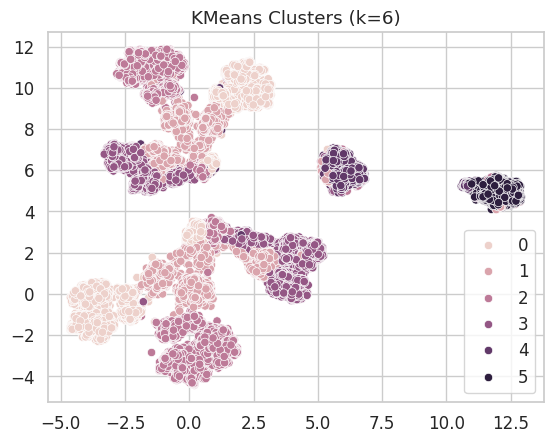

In [ ]:
# K-Means Clustering
kmeans = KMeans(n_clusters=6, random_state=42, n_init=20)
labels_km = kmeans.fit_predict(X_pca)

#UMAP 2d Visualization
import umap
um = umap.UMAP(n_neighbors=40, min_dist=0.05, random_state=42)
emb = um.fit_transform(X_pca)

sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=labels_km)
plt.title("KMeans Clusters (k=6)")


# GMM Clustering

Text(0.5, 1.0, 'GMM Clusters (k=6)')

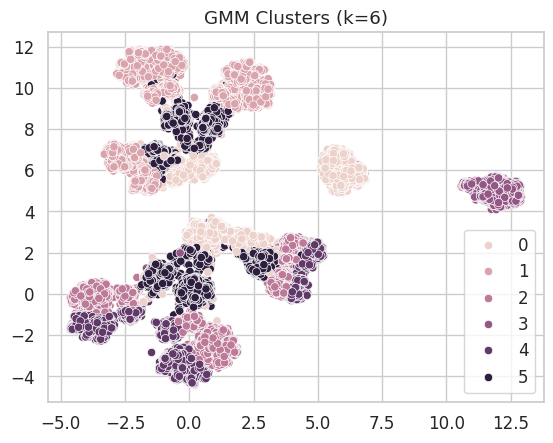

In [ ]:
# GMM Clustering
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=6, random_state=42, covariance_type='full')
labels_gmm = gmm.fit_predict(X_pca)

sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=labels_gmm)
plt.title("GMM Clusters (k=6)")

# Diagnostics

- scree plot
- PCA Explained Variance
- PCA Loadings
- Silhouette Score
- Cluster Labels

In [ ]:
# Replace NaNa and Recompute PCA (for Scree Plot)
X_scaled = np.nan_to_num(X_scaled, nan=0.0)
pca = PCA(n_components=12, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# PCA Explained Variance
expl_var = pca.explained_variance_ratio_
pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(expl_var))],
    "Variance": expl_var,
    "Percent": expl_var * 100,
    "Cumulative": expl_var.cumsum() * 100
})


,PC,Variance,Percent,Cumulative
0,PC1,0.081835,8.183537,8.183537
1,PC2,0.035792,3.579244,11.762782
2,PC3,0.033465,3.346452,15.109233
3,PC4,0.031276,3.127629,18.236862
4,PC5,0.027423,2.742297,20.979160
5,PC6,0.025200,2.519961,23.499121
6,PC7,0.023117,2.311704,25.810825
7,PC8,0.022414,2.241418,28.052243
8,PC9,0.021832,2.183206,30.235448
9,PC10,0.020792,2.079193,32.314641


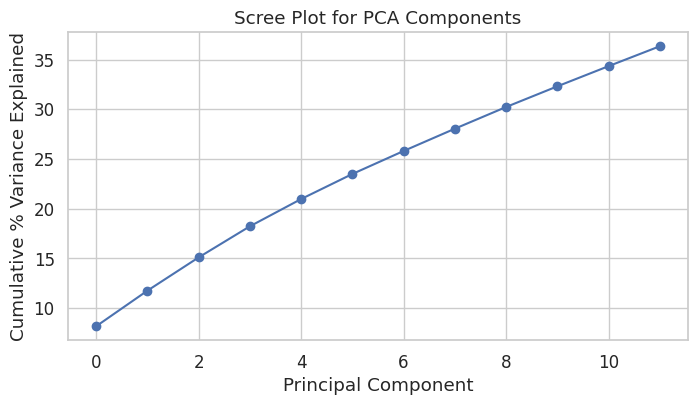

In [ ]:
# Scree Plot
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative % Variance Explained")
plt.title("Scree Plot for PCA Components")
plt.grid(True)


In [ ]:
# PCA Loadings (Featire Importance per PC)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.columns
)

loadings.abs().nlargest(10, "PC1")


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
chronic_count,0.324782,0.097173,0.143472,0.004360,0.116725,0.131677,0.007452,0.015058,0.007893,0.003087,0.164082,0.037294
risk_score,0.316195,0.052998,0.290030,0.013223,0.017933,0.050005,0.001975,0.030317,0.010782,0.005707,0.030831,0.005219
is_high_risk,0.274674,0.053356,0.258036,0.014509,0.005634,0.070083,0.002665,0.036484,0.005384,0.008809,0.047891,0.009421
annual_medical_cost,0.260160,0.321894,0.072624,0.011726,0.279287,0.022122,0.013284,0.137426,0.018657,0.002430,0.039986,0.000436
total_claims_paid,0.259881,0.220475,0.381720,0.027984,0.018749,0.116762,0.007225,0.016954,0.008561,0.007331,0.093748,0.019982
claims_count,0.259359,0.264853,0.313720,0.027890,0.043493,0.082551,0.005763,0.038226,0.008874,0.003223,0.056415,0.010651
annual_premium,0.258547,0.340625,0.079255,0.010194,0.295955,0.025463,0.015617,0.160769,0.019312,0.005840,0.053096,0.004374
monthly_premium,0.258376,0.340651,0.079303,0.010186,0.295718,0.025441,0.015618,0.160760,0.019281,0.005841,0.053057,0.004375
avg_claim_amount,0.242891,0.204464,0.383294,0.027024,0.030167,0.122179,0.007569,0.012981,0.008396,0.008203,0.101694,0.021868
visits_last_year,0.242699,0.220292,0.254571,0.024939,0.036583,0.062387,0.002804,0.025929,0.007889,0.002875,0.030383,0.005535


In [ ]:
# Number of top features to extract
TOP_N = 10

# Absolute loadings
load_abs = loadings.abs()

top_pc1 = load_abs['PC1'].nlargest(TOP_N)
top_pc2 = load_abs['PC2'].nlargest(TOP_N)
top_pc3 = load_abs['PC3'].nlargest(TOP_N)

print("Top PC1 Features:")
print(top_pc1, "\n")

print("Top PC2 Features:")
print(top_pc2, "\n")

print("Top PC3 Features:")
print(top_pc3)


Top PC1 Features:
chronic_count          0.324782
risk_score             0.316195
is_high_risk           0.274674
annual_medical_cost    0.260160
total_claims_paid      0.259881
claims_count           0.259359
annual_premium         0.258547
monthly_premium        0.258376
avg_claim_amount       0.242891
visits_last_year       0.242699
Name: PC1, dtype: float64 

Top PC2 Features:
days_hospitalized_last_3yrs    0.409494
hospitalizations_last_3yrs     0.396234
monthly_premium                0.340651
annual_premium                 0.340625
annual_medical_cost            0.321894
claims_count                   0.264853
had_major_procedure            0.252195
total_claims_paid              0.220475
visits_last_year               0.220292
avg_claim_amount               0.204464
Name: PC2, dtype: float64 

Top PC3 Features:
avg_claim_amount     0.383294
total_claims_paid    0.381720
claims_count         0.313720
systolic_bp          0.311158
age                  0.298546
risk_score          

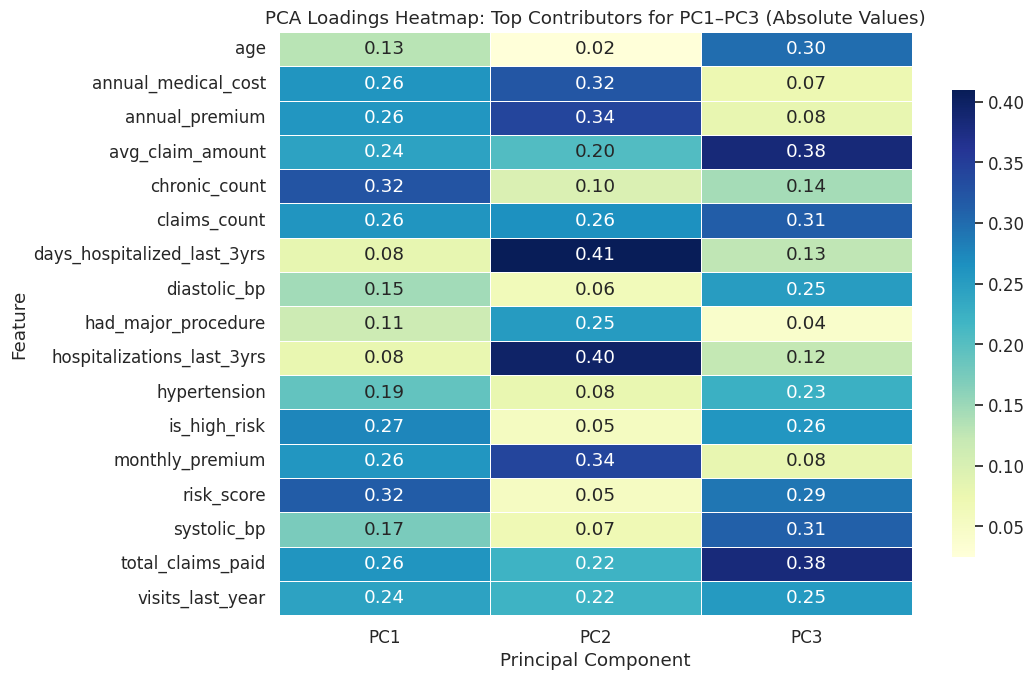

In [ ]:
# Combine top features across the three PCs
features_union = (
    top_pc1.index
    .union(top_pc2.index)
    .union(top_pc3.index)
)

heatmap_df = load_abs.loc[features_union, ['PC1', 'PC2', 'PC3']]

plt.figure(figsize=(11, 7))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)

plt.title("PCA Loadings Heatmap: Top Contributors for PC1–PC3 (Absolute Values)")
plt.xlabel("Principal Component")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
# Silhouette Score
sil = silhouette_score(X_pca, labels_gmm) # or labels_km
print("Silhouette Score:", sil)


Silhouette Score: 0.08048155603045277


In [ ]:
# Add cluster labels
df['cluster_gmm'] = labels_gmm  # or labels_km

# Separate numeric & categorical
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object','category','bool']).columns

# Numerical summaries
print("\n===== NUMERIC PROFILE BY CLUSTER =====")
display(df.groupby('cluster_gmm')[num_cols].mean().round(2))

# Categorical summaries (proportions)
print("\n===== CATEGORICAL PROFILE BY CLUSTER =====")
for col in cat_cols:
    print(f"\n--- {col} distribution ---")
    display(df.groupby('cluster_gmm')[col].value_counts(normalize=True).mul(100).round(1))



===== NUMERIC PROFILE BY CLUSTER =====


,person_id,age,income,household_size,dependents,bmi,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,...,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure,cluster_gmm
cluster_gmm,,,,,,,,,,,,,,,,,,,,,
0,49853.49,44.97,49505.68,2.43,0.90,26.92,0.97,0.34,0.74,1.34,...,0.15,0.18,0.54,0.71,0.55,0.54,0.54,0.37,0.81,0.0
1,49973.26,44.21,49866.82,2.43,0.90,26.97,0.42,0.00,0.00,0.99,...,0.05,0.06,0.46,0.00,0.45,0.45,0.44,0.18,0.00,1.0
2,50112.89,44.87,50597.93,1.90,0.90,27.00,1.16,0.00,0.00,1.23,...,0.12,0.14,0.50,0.00,0.51,0.50,0.51,0.32,0.00,2.0
3,49761.84,46.20,50388.12,2.43,0.89,27.07,1.18,0.08,0.17,1.77,...,0.11,0.12,0.66,0.29,0.64,0.63,0.63,0.64,0.24,3.0
4,50135.02,44.86,49543.22,2.91,0.91,26.96,1.15,0.00,0.00,1.22,...,0.12,0.15,0.50,0.00,0.50,0.51,0.51,0.33,0.00,4.0
5,50064.10,44.42,49330.11,2.42,0.90,27.09,0.87,0.00,0.00,1.14,...,0.10,0.12,0.48,0.09,0.48,0.48,0.49,0.19,0.09,5.0



===== CATEGORICAL PROFILE BY CLUSTER =====

--- sex distribution ---


cluster_gmm  sex   
0            Male      49.1
             Female    48.9
             Other      2.0
1            Female    49.4
             Male      48.5
             Other      2.1
2            Female    49.0
             Male      49.0
             Other      2.1
3            Male      49.6
             Female    48.7
             Other      1.7
4            Female    49.4
             Male      48.5
             Other      2.1
5            Female    50.1
             Male      47.9
             Other      2.0
Name: proportion, dtype: float64


--- region distribution ---


cluster_gmm  region 
0            South      28.3
             North      22.4
             East       19.5
             West       18.1
             Central    11.7
1            South      27.9
             North      22.1
             East       20.2
             West       17.8
             Central    12.0
2            South      28.1
             North      21.8
             East       20.5
             West       17.6
             Central    12.0
3            South      28.3
             North      22.0
             East       19.8
             West       17.5
             Central    12.4
4            South      27.9
             North      21.9
             East       20.0
             West       17.8
             Central    12.4
5            South      27.5
             North      22.2
             East       20.1
             West       17.9
             Central    12.4
Name: proportion, dtype: float64


--- urban_rural distribution ---


cluster_gmm  urban_rural
0            Urban          59.8
             Suburban       25.4
             Rural          14.8
1            Urban          60.5
             Suburban       24.7
             Rural          14.8
2            Urban          60.2
             Suburban       25.0
             Rural          14.8
3            Urban          58.8
             Suburban       25.6
             Rural          15.6
4            Urban          60.2
             Suburban       24.9
             Rural          14.9
5            Urban          60.1
             Suburban       24.9
             Rural          15.0
Name: proportion, dtype: float64


--- education distribution ---


cluster_gmm  education   
0            Bachelors       27.2
             Some College    25.4
             HS              25.3
             Masters         14.0
             No HS            5.1
             Doctorate        2.9
1            Bachelors       28.4
             Some College    25.3
             HS              24.5
             Masters         13.8
             No HS            5.2
             Doctorate        2.9
2            Bachelors       27.8
             HS              25.6
             Some College    25.1
             Masters         13.6
             No HS            5.1
             Doctorate        2.9
3            Bachelors       27.7
             HS              25.2
             Some College    25.2
             Masters         14.0
             No HS            5.1
             Doctorate        2.9
4            Bachelors       28.0
             Some College    25.0
             HS              24.9
             Masters         14.3
             No HS            4.9
             Doctorate        3.0
5            Bachelors       28.4
             Some College    24.9
             HS              24.5
             Masters         14.1
             No HS            4.8
             Doctorate        3.2
Name: proportion, dtype: float64


--- marital_status distribution ---


cluster_gmm  marital_status
0            Married            52.7
             Single             35.8
             Divorced            7.2
             Widowed             4.3
1            Married            53.3
             Single             35.7
             Divorced            7.0
             Widowed             3.9
2            Single             76.5
             Divorced           14.8
             Widowed             8.7
             Married             0.0
3            Married            53.7
             Single             36.2
             Divorced            6.7
             Widowed             3.3
4            Married           100.0
5            Married            52.4
             Single             36.5
             Divorced            6.8
             Widowed             4.2
Name: proportion, dtype: float64


--- employment_status distribution ---


cluster_gmm  employment_status
0            Employed             55.4
             Retired              19.4
             Unemployed           13.0
             Self-employed        12.2
1            Employed             55.3
             Retired              19.9
             Unemployed           12.7
             Self-employed        12.1
2            Employed             54.8
             Retired              20.3
             Unemployed           13.1
             Self-employed        11.7
3            Employed             54.7
             Retired              20.3
             Unemployed           13.3
             Self-employed        11.7
4            Employed             55.5
             Retired              19.8
             Unemployed           13.0
             Self-employed        11.7
5            Employed             56.0
             Retired              19.7
             Unemployed           12.7
             Self-employed        11.7
Name: proportion, dtype: float64


--- smoker distribution ---


cluster_gmm  smoker 
0            Never       75.5
             Current     12.9
             Former      11.6
1            Never       85.2
             Current     14.8
2            Never       85.5
             Current     14.5
3            Never       69.8
             Former      17.9
             Current     12.3
4            Never       84.7
             Current     15.3
5            Former     100.0
Name: proportion, dtype: float64


--- alcohol_freq distribution ---


cluster_gmm  alcohol_freq
0            Occasional      44.3
             Never           30.7
             Weekly          20.1
             Daily            5.0
1            Occasional      45.3
             Never           30.4
             Weekly          19.4
             Daily            4.9
2            Occasional      44.8
             Never           30.5
             Weekly          19.7
             Daily            5.0
3            Occasional      46.1
             Never           29.9
             Weekly          19.0
             Daily            5.0
4            Occasional      45.2
             Never           29.8
             Weekly          20.1
             Daily            5.0
5            Occasional      44.7
             Never           29.7
             Weekly          20.3
             Daily            5.3
Name: proportion, dtype: float64


--- plan_type distribution ---


cluster_gmm  plan_type
0            PPO          35.6
             HMO          34.6
             EPO          15.1
             POS          14.7
1            PPO          35.3
             HMO          35.1
             EPO          15.1
             POS          14.5
2            HMO          35.2
             PPO          34.5
             POS          15.2
             EPO          15.1
3            PPO          35.9
             HMO          33.8
             EPO          15.2
             POS          15.1
4            HMO          34.9
             PPO          34.8
             EPO          15.4
             POS          15.0
5            PPO          35.5
             HMO          34.3
             POS          15.4
             EPO          14.8
Name: proportion, dtype: float64


--- network_tier distribution ---


cluster_gmm  network_tier
0            Silver          40.4
             Bronze          30.0
             Gold            19.6
             Platinum         9.9
1            Silver          39.9
             Bronze          30.2
             Gold            19.9
             Platinum        10.0
2            Silver          39.7
             Bronze          29.9
             Gold            20.5
             Platinum        10.0
3            Silver          40.8
             Bronze          29.5
             Gold            19.0
             Platinum        10.8
4            Silver          40.3
             Bronze          29.9
             Gold            19.9
             Platinum         9.8
5            Silver          39.8
             Bronze          30.0
             Gold            20.3
             Platinum         9.8
Name: proportion, dtype: float64